In [2]:
import numpy as np
import matplotlib.pyplot as plt
from objfun_stybtang import StyblinskiTang
from objfun_shubert3 import Shubert3
from objfun_mmm import MMM
from heur_gso import GlowwormSwarm
from heur_fsa import FastSimulatedAnnealing
from heur_aux import CauchyMutation, Correction, MirrorCorrection, ExtensionCorrection
import pandas as pd
import seaborn as sns
from misc import experiment, optima, mne, rel, feo, mcmult
from IPython.display import display, HTML

%load_ext autoreload
%autoreload 2


# Glowworm swarm optimization

Glowworm swarm optimization (GSO) is a method inspired by the behaviour of glowworms who emit light in order to attract mates. They produce lgiht using the luciferin biolominiscent compound.

The method is based on increasing the bugs' light intensity -- i. e. the luciferin level -- proportionally to the objective function. Brighter glowworms located in regions of higher objective function value attract those that have lower intensity. They follow a constant movement step and consider other glowworms in their range which varies depending on the amount of glowworms in their neighbourhood.

The glowworms get together around local maxima and converge to them simultaneously, thus the method is suitable for multimodal optimization.

## Algorithm
GSO starts be placing a population of $n$ agent randomly in the search space and they are assighned initial luciferin level $\ell_i=\ell_0$, initial range equal to the maximum range $r_i=r_s$.
Each iterations consists of three phases:
1. Luciferin update:
The luciferin level decays with coefficient $\rho$. Also it is increased proportionally to the objective function value at the agent's location using the coefficient $\gamma$ (the method is stated to search the maximum),
$$ \ell_i \leftarrow (1-\rho)\ell_i+\gamma f(x_i).$$
2. Direction choice and movement:
The agent chooses one of its neighbours (in the neightbourhood $\mathcal{N}$), that is in its range and has a higher luciferin level,
$$ \mathcal{N}_i = \big\{ j\in\widehat{n} : 0<\lVert x_i-x_j\rVert<r_i \wedge \ell_j > \ell_i \big\}. $$
The agent $i$ chooses to move towards the agentovi $j$ with the probability $\pi_{i,j}$,
$$ \pi_{i,j} = \begin{cases}
    \frac{1}{ \sum_{\mathcal{N}_i} \ell_j} \ell_j       & \quad \text{if } j\in\mathcal{N}_i\\
    0  & \quad \text{otherwise.}
  \end{cases} $$
Then it moves by the step $s$ in chosen direction,
$$ x_i \leftarrow x_i + s\frac{x_j-x_i}{\lVert x_j-x_i\rVert}. $$
3. Range update:
The agents update their ranges according to
$$ r_i \leftarrow \frac{r_s}{1+\beta D_i}, \quad \text{kde} \quad D_i=\frac{\lvert \mathcal{N}_i \rvert}{\pi r_s^2}, $$
i. e. increasing agents density $D$ in the neighbourhood leads to reducing their range, moreover the agent with no suitable neighbour sets its range as long as possible.

### Algortihm problems
- There are recommended parameters values $\rho=0.4$, $\gamma=0,6$, $\beta=0.08$, $\ell_0=5$ a $s=0.03$; which are introduced as universal and parameters $n$ and $r_s$ are to be tuned. 
    - Obviously, at least the step $s$ is to be chosen by the size of the search space - the glowworms would fly from one boundary to another if the space is smaller than $s$, on the contrary, in large space the step may be negligible.
    - The initial luciferin level $\ell_0$ may depend on the objective function scaling - if $f(x)\gg\ell_0$, the luciferin level will change substatially on first update and the initial parameter is irrelevant, if $f(x)\ll\ell_0$, the luciferin level would not change significantly, thus the probabilities $\pi_{i,j}$ would approximately match the uniform distribution.
- When maximizing an negative function using the formulae above $\ell_i$ may decrease to negatives leading to negative probabilities. To prevent this, there is a variant of the formula: $ \ell_i \leftarrow \max \{0;(1-\rho)\ell_i+\gamma f(x_i)\}$, however, this leads to another diffculties.

### Application
* In order to search for minima instead of maxima, the parametr $\gamma$ has been chosen to negative.
* Also the objective function has been decreased by an appropriate constant so that $f(x)$ is negative and $\ell_i$ non-negative.
* Parameter $\ell_0$ has been set to zero (despite the recommendations).
* Parameters $\rho=0.4$, $\gamma=-0.6$ and $\beta=0.08$ have been set according to the recommendations (or with opposite sign), because changing the values has not brought significant improvement.
* $n$, $s$ a $r_s$ left to be tuned.
* Sticky boundaries have been used as correction.

## Benchmark functions
### Styblinski–Tang
$$f(x)=\frac{1}{2}\sum_{i=1}^d x_i^4-16x_i^2+5x_i\quad\text{on }\langle -5;5\rangle^d$$
Dimensions $d$, single global minimum, $2^d$ local minima.
### Shubert 3
$$f(x)=\sum_{i=1}^d\sum_{j=1}^5 j\sin[(j+1)x_i+j)\quad\text{on }\langle -10;10\rangle^d$$
Dimensions $d$, $3^d$ global minima, many local minima.

<tr><td>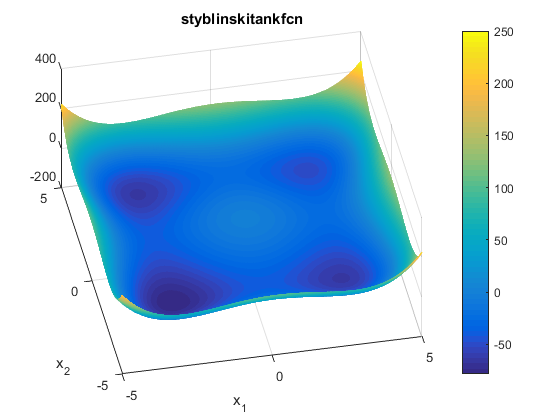</td><td>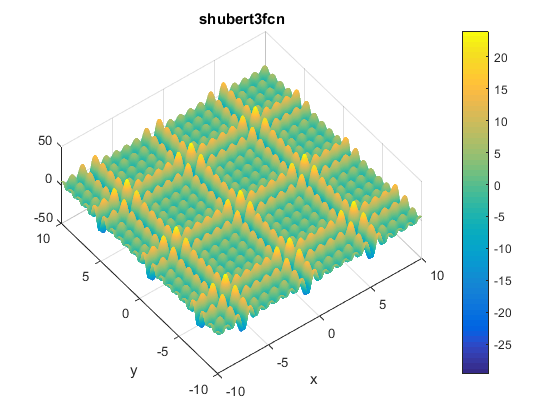</td></tr>

## Analysis

### Aims
* try both benchmark functions
* go through higher dimensions: 2, 4, 8, 16
* compare with FSA (Cauchy mutation, sticky boundaries), tuned parameters $T_0$, $n_0$, $\alpha$, $r$
* minimize Feoktistov's criterion

In [2]:
all_results = pd.DataFrame()

### Dimension 2

#### Styblinski-Tang

In [3]:
prb = StyblinskiTang(dim=2)
x = np.linspace(prb.a[0], prb.b[0], 1000)
y = np.linspace(prb.a[1], prb.b[1], 1000)
x, y = np.meshgrid(x, y)
f = prb.evaluate(np.stack([x.ravel(), y.ravel()], axis=1)).reshape(x.shape)

In [4]:
# parametry
n = 10
s = 0.5
rs = 15
beta = 0.08
gamma = -.6

alpha = 1
n0 = 15
T0 = 2
r = 0.25

num_runs = 100

In [5]:
# GSO
gso = GlowwormSwarm(prb, maxeval=10e3, n=n, rs=rs, s=s, beta=beta, eps=0.05, l0=0, gamma=gamma)
res_gso = gso.search()

In [6]:
# FSA
cauchy = CauchyMutation(r=r, correction=Correction(prb))
fsa = FastSimulatedAnnealing(prb, maxeval=10000, T0=T0, n0=n0, alpha=alpha, mutation=cauchy, eps=0.05)
res_fsa = fsa.search()

Text(0.5, 1.0, 'FSA')

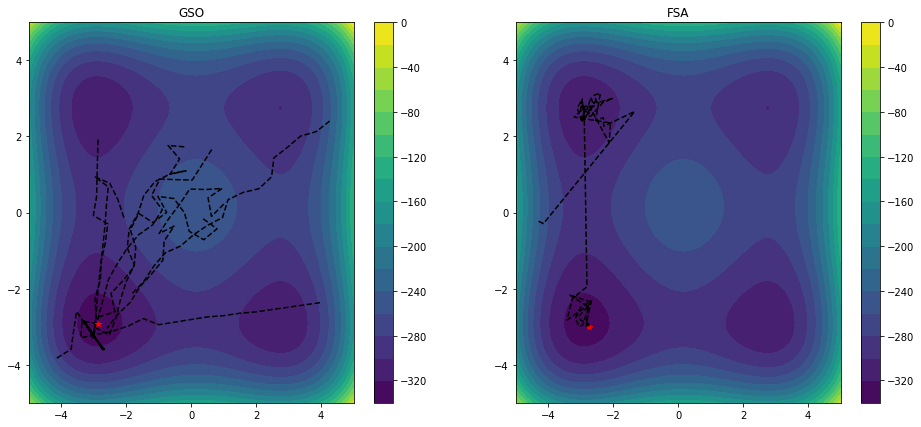

In [7]:
# ukázka trajektorie
fig, axes = plt.subplots(1, 2, figsize=[16, 7])
im = axes[0].contourf(x, y, f, levels=20)
plt.colorbar(im, ax = axes[0])
#axes[0].plot(res_gso['log_data']['x'].iloc[-1][:, 0], res_gso['log_data']['x'].iloc[-1][:, 1], 'k.')
for i in range(n):
    axes[0].plot([res_gso['log_data']['x'].iloc[j][i, 0] for j in range(res_gso['log_data'].shape[0])], [res_gso['log_data']['x'].iloc[j][i, 1] for j in range(res_gso['log_data'].shape[0])], 'k--')
axes[0].plot(res_gso['best_x'][0], res_gso['best_x'][1], 'r*')
axes[0].set_title('GSO')
im = axes[1].contourf(x, y, f, levels=20)
plt.colorbar(im, ax = axes[1])
axes[1].plot(res_fsa['log_data']['x'].iloc[-1][0, 0], res_fsa['log_data']['x'].iloc[-1][0, 1], 'r*')
axes[1].plot([res_fsa['log_data']['x'].iloc[j][0,0] for j in range(res_fsa['log_data'].shape[0])], [res_fsa['log_data']['x'].iloc[j][0,1] for j in range(res_fsa['log_data'].shape[0])], 'k--')
axes[1].set_title('FSA')

In [8]:
res = experiment(prb, GlowwormSwarm, num_runs=num_runs, desc={'alg': 'GSO', 'prob': 'S-T', 'dim': prb.dim},
                 params={'maxeval': 10000, 'n': n, 's': s, 'rs': rs, 'beta': beta, 'eps': 0.05, 'l0': 0, 'gamma': gamma},
                 optdist=3, optthreshold=-280)
all_results = pd.concat([all_results, res], axis=0, sort=False)
cauchy = CauchyMutation(r=r, correction=Correction(prb))
res = experiment(prb, FastSimulatedAnnealing, num_runs=num_runs, desc={'alg': 'FSA', 'prob': 'S-T', 'dim': prb.dim, 'r': r},
                 params={'maxeval': 10000, 'T0': T0, 'n0': n0, 'alpha': alpha, 'mutation': cauchy, 'eps': 0.05})
all_results = pd.concat([all_results, res], axis=0, sort=False)

#### Shubert 3

In [9]:
shu = Shubert3(dim=2, range='large')
x = np.linspace(shu.a[0], shu.b[0], 1000)
y = np.linspace(shu.a[1], shu.b[1], 1000)
x, y = np.meshgrid(x, y)
f = shu.evaluate(np.stack([x.ravel(), y.ravel()], axis=1)).reshape(x.shape)

In [10]:
# parametry
n = 7
s = 0.25
rs = 60

alpha = 1.5
n0 = 10
T0 = 2
r = 0.1

In [11]:
# GSO
gso = GlowwormSwarm(shu, maxeval=10e3, n=n, rs=rs, s=s, beta=beta, eps=0.05, l0=0, gamma=gamma)
res_gso = gso.search()

In [12]:
# FSA
cauchy = CauchyMutation(r=r, correction=Correction(shu))
fsa = FastSimulatedAnnealing(shu, maxeval=10000, T0=T0, n0=n0, alpha=alpha, mutation=cauchy, eps=0.05)
res_fsa = fsa.search()

Text(0.5, 1.0, 'FSA')

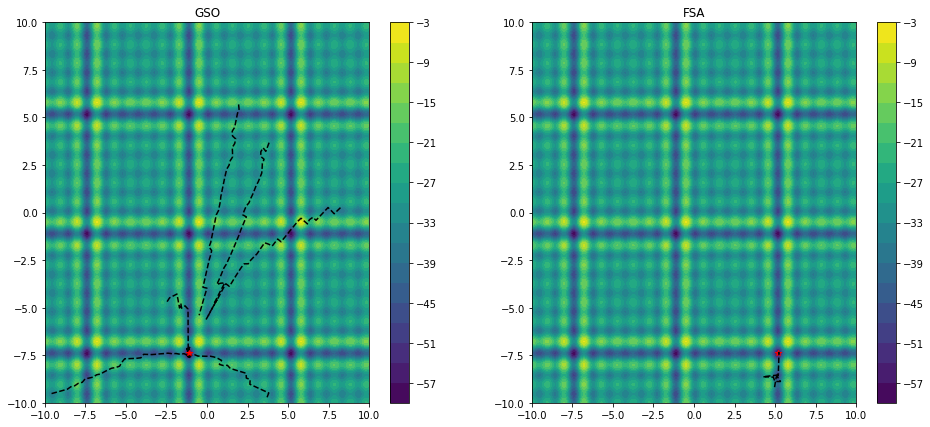

In [13]:
# ukázka trajektorie
fig, axes = plt.subplots(1, 2, figsize=[16, 7])
im = axes[0].contourf(x, y, f, levels=20)
plt.colorbar(im, ax = axes[0])
#axes[0].plot(res_gso['log_data']['x'].iloc[-1][:, 0], res_gso['log_data']['x'].iloc[-1][:, 1], 'k.')
for i in range(n):
    axes[0].plot([res_gso['log_data']['x'].iloc[j][i, 0] for j in range(res_gso['log_data'].shape[0])], [res_gso['log_data']['x'].iloc[j][i, 1] for j in range(res_gso['log_data'].shape[0])], 'k--')
axes[0].plot(res_gso['best_x'][0], res_gso['best_x'][1], 'r*')
axes[0].set_title('GSO')
im = axes[1].contourf(x, y, f, levels=20)
plt.colorbar(im, ax = axes[1])
axes[1].plot(res_fsa['log_data']['x'].iloc[-1][0, 0], res_fsa['log_data']['x'].iloc[-1][0, 1], 'r*')
axes[1].plot([res_fsa['log_data']['x'].iloc[j][0,0] for j in range(res_fsa['log_data'].shape[0])], [res_fsa['log_data']['x'].iloc[j][0,1] for j in range(res_fsa['log_data'].shape[0])], 'k--')
axes[1].set_title('FSA')

In [14]:
res = experiment(shu, GlowwormSwarm, num_runs=num_runs, desc={'alg': 'GSO', 'prob': 'Shu3', 'dim': shu.dim},
                 params={'maxeval': 10000, 'n': n, 's': s, 'rs': rs, 'beta': beta, 'eps': 0.05, 'l0': 0, 'gamma': gamma},
                 optdist=3, optthreshold=-280)
all_results = pd.concat([all_results, res], axis=0, sort=False)
cauchy = CauchyMutation(r=r, correction=Correction(shu))
res = experiment(shu, FastSimulatedAnnealing, num_runs=num_runs, desc={'alg': 'FSA', 'prob': 'Shu3', 'dim': shu.dim, 'r': r},
                 params={'maxeval': 10000, 'T0': T0, 'n0': n0, 'alpha': alpha, 'mutation': cauchy, 'eps': 0.05})
all_results = pd.concat([all_results, res], axis=0, sort=False)

#### Srovnání

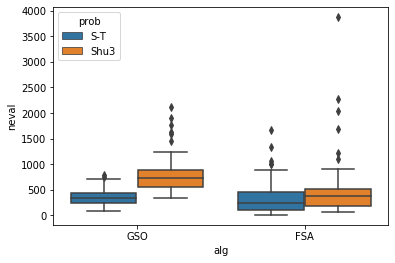

In [15]:
all_results['best_y'] = all_results['best_y'].apply(lambda x: x if type(x)==float else x.item())
sns.boxplot(x='alg', y='neval', hue='prob', data=all_results.where((all_results['neval']<np.inf)&(all_results['dim']==2)))

In [16]:
stats = all_results.where(all_results['dim']==2).pivot_table(
    index=['alg', 'prob'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats = stats.reset_index()
stats.head()

,alg,prob,feo,mne,rel
0,FSA,S-T,327.450000,327.450000,1.00
1,FSA,Shu3,460.650000,460.650000,1.00
2,GSO,S-T,550.505051,363.333333,0.66
3,GSO,Shu3,1605.882353,819.000000,0.51


* For both benchmark functions FSA is better based on the comparison of reliability, mean number of evaluation and FEO.
* When tuning the parameter to minimize FEO, the maximal range $r_s$ was chosen to be equal to the space size (or higher), therefore many glowworms sees each other, which supressed the ability of multimodal optimization.

### Dimension 4

In [19]:
prb = StyblinskiTang(dim=4)
shu = Shubert3(dim=4, range='large')

In [20]:
n = 60
s = 0.5
rs = 20

alpha = 1.5
n0 = 10
T0 = 4
r = 0.25

In [21]:
res = experiment(prb, GlowwormSwarm, num_runs=num_runs, desc={'alg': 'GSO', 'prob': 'S-T', 'dim': prb.dim},
                 params={'maxeval': 10000, 'n': n, 's': s, 'rs': rs, 'beta': beta, 'eps': 0.05, 'l0': 0, 'gamma': gamma},
                 optdist=3, optthreshold=-280)
all_results = pd.concat([all_results, res], axis=0, sort=False)
cauchy = CauchyMutation(r=r, correction=Correction(prb))
res = experiment(prb, FastSimulatedAnnealing, num_runs=num_runs, desc={'alg': 'FSA', 'prob': 'S-T', 'dim': prb.dim, 'r': r},
                 params={'maxeval': 10000, 'T0': T0, 'n0': n0, 'alpha': alpha, 'mutation': cauchy, 'eps': 0.05})
all_results = pd.concat([all_results, res], axis=0, sort=False)

In [22]:
n = 30
s = 0.25
rs = 60

alpha = 2
n0 = 5
T0 = 5
r = 0.03

In [23]:
res = experiment(shu, GlowwormSwarm, num_runs=num_runs, desc={'alg': 'GSO', 'prob': 'Shu3', 'dim': shu.dim},
                 params={'maxeval': 10000, 'n': n, 's': s, 'rs': rs, 'beta': beta, 'eps': 0.05, 'l0': 0, 'gamma': gamma},
                 optdist=3, optthreshold=-280)
all_results = pd.concat([all_results, res], axis=0, sort=False)
cauchy = CauchyMutation(r=r, correction=Correction(shu))
res = experiment(shu, FastSimulatedAnnealing, num_runs=num_runs, desc={'alg': 'FSA', 'prob': 'Shu3', 'dim': shu.dim, 'r': r},
                 params={'maxeval': 10000, 'T0': T0, 'n0': n0, 'alpha': alpha, 'mutation': cauchy, 'eps': 0.05})
all_results = pd.concat([all_results, res], axis=0, sort=False)

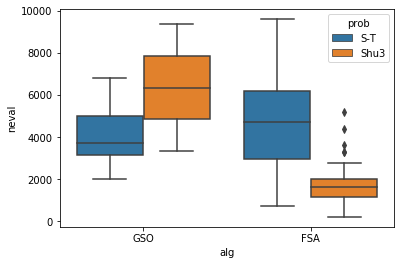

In [24]:
all_results['best_y'] = all_results['best_y'].apply(lambda x: x if type(x)==float else x.item())
sns.boxplot(x='alg', y='neval', hue='prob', data=all_results.where((all_results['neval']<np.inf)&(all_results['dim']==4)))

In [25]:
stats = all_results.where(all_results['dim']==4).pivot_table(
    index=['alg', 'prob'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats = stats.reset_index()
stats.head()

,alg,prob,feo,mne,rel
0,FSA,S-T,7632.733136,4655.967213,0.61
1,FSA,Shu3,1645.150000,1645.150000,1.00
2,GSO,S-T,12132.231405,4003.636364,0.33
3,GSO,Shu3,317250.000000,6345.000000,0.02


* The benchmark functions results differs substantially. Whereas using Styblinski-Tang the results are similar between FSA and GSO, when using Shubert 3, GSO loses with minimal reliability while FSA can find one of the 81 global minima seamlessly.
* Again the high range suppresses search multiple minima.

### Dimesions 8 and 16

No configuration of parameters was found to find any solution.

### Find multiple / all optima

In order to examine the GSO's ability of multimodal optimization, a common multimodal function was developed having four equal minima (in 2d). Shubert 3 seems to be too difficualt for such algorithm.
$$f(x)=-\sum_{i=1}^d 3x_i^2\cos(x_i)+x_i^2\cos(4x_i)-x_i^2\cos(8x_i)\quad\text{na }\langle -2;2\rangle^d$$

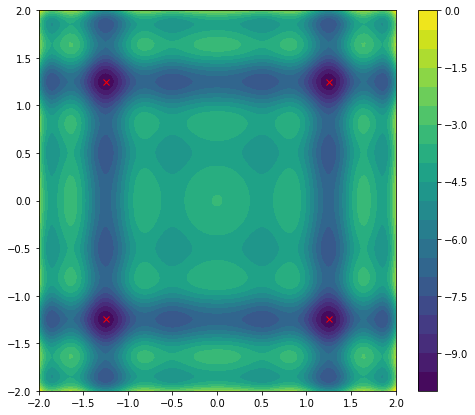

In [26]:
mmm = MMM(dim=2)
x = np.linspace(mmm.a[0], mmm.b[0], 150)
y = np.linspace(mmm.a[1], mmm.b[1], 150)
x, y = np.meshgrid(x, y)
f = mmm.evaluate(np.stack([x.ravel(), y.ravel()], axis=1)).reshape(x.shape)
plt.figure(figsize=[8, 7])
plt.contourf(x, y, f, levels=20)
plt.colorbar(); plt.plot(x[f<=mmm.get_fstar()+0.03], y[f<=mmm.get_fstar()+0.03], 'rx')

In [27]:
n = 300
s = 0.5
rs = 1.5
maxeval = 1000 

res = experiment(mmm, GlowwormSwarm, num_runs=num_runs, desc={'alg': 'GSO', 'dim': mmm.dim},
    params={'maxeval': maxeval, 'n': n, 's': s, 'rs': rs, 'beta': beta, 'eps': -0.05, 'l0': 0, 'gamma': gamma},
    optdist=1, optthreshold=mmm.get_fstar()+0.1)

In [28]:
table = pd.DataFrame()
n = [100, 250, 500]
s = [0.5]
rs = [1.5, 1, 2.5]
maxeval = [500, 1000, 1500]

i = 1
for n_ in n:
    for s_ in s:
        for rs_ in rs:
            for maxeval_ in maxeval:
                res = experiment(mmm, GlowwormSwarm, num_runs=100, text=str(i), desc={'alg': 'GSO', 'dim': mmm.dim},
                                 params={'maxeval': maxeval_, 'n': n_, 's': s_, 'rs': rs_, 'beta': beta, 'eps': -0.05, 'l0': 0, 'gamma': gamma},
                                 optdist=1, optthreshold=mmm.get_fstar()+0.1)
                table = pd.concat([table, res], axis=0); i += 1

In [29]:
alpha = 2
n0 = 1
T0 = 5
r = .2
maxeval = 1000
num_runs = 100

cauchy = CauchyMutation(r=.1, correction=Correction(mmm))
res_fsa = experiment(mmm, FastSimulatedAnnealing, num_runs=num_runs, text=str(i), desc={'alg': 'FSA', 'dim': mmm.dim, 'r': r},
                 params={'maxeval': maxeval, 'T0': T0, 'n0': n0, 'alpha': alpha, 'mutation': cauchy, 'eps': 0.1})

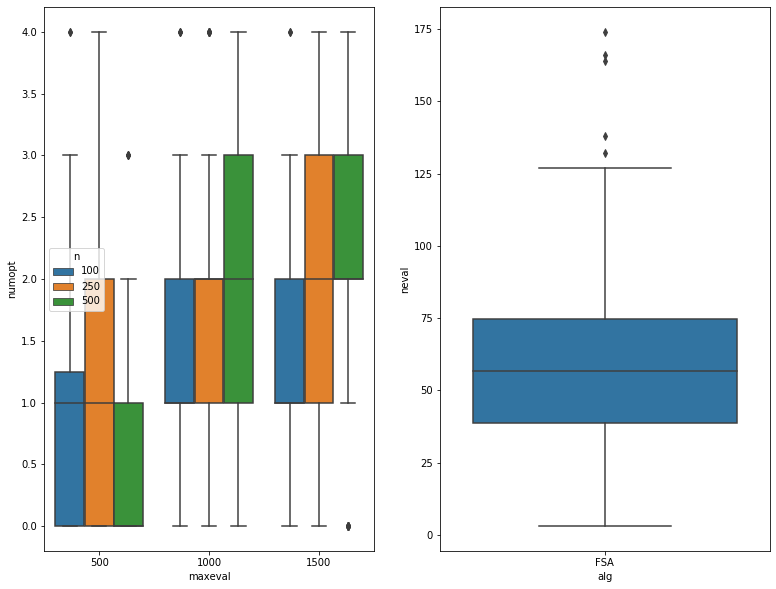

In [30]:
f, axes = plt.subplots(1, 2, figsize=[13, 10])
sns.boxplot(x='maxeval', y='numopt', hue='n', data=table, ax=axes[0])
sns.boxplot(x='alg', y='neval', data=res_fsa, ax=axes[1])

In [31]:
stats = table.pivot_table(
    index=['n', 's', 'rs', 'maxeval'],
    values=['numopt'],
    aggfunc=('mean')
)['numopt']
stats = stats.reset_index()
stats['crit'] = stats['maxeval'] / stats['numopt']
display(stats.sort_values('numopt', ascending=False).head(5))
display(stats.sort_values('crit').head(5))

,n,s,rs,maxeval,numopt,crit
23,500,0.5,1.5,1500,2.69,557.620818
20,500,0.5,1.0,1500,2.36,635.593220
14,250,0.5,1.5,1500,2.29,655.021834
11,250,0.5,1.0,1500,2.13,704.225352
19,500,0.5,1.0,1000,2.11,473.933649


,n,s,rs,maxeval,numopt,crit
12,250,0.5,1.5,500,1.28,390.625000
9,250,0.5,1.0,500,1.25,400.000000
3,100,0.5,1.5,500,1.18,423.728814
0,100,0.5,1.0,500,1.13,442.477876
19,500,0.5,1.0,1000,2.11,473.933649


In [32]:
stats_fsa = res_fsa.pivot_table(
    index=['alpha', 'T0', 'n0', 'r'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
display(stats_fsa.sort_values('feo').head(5))

,alpha,T0,n0,r,feo,mne,rel
0,2,5,1,0.2,61.44,61.44,1.0


* A criterion of (number of evaluations)/(number of optima found) was chosen to evaluate the algorithms, $\text{crit}=\text{neval}/\text{numopt}$. It can be seen that the minimal criterion value does not guarantee most optima to be found at once. Anyway, hundred of evaluations are need to find a single optimum.
* FSA converges to a single minimum in 61 evaluations in average with a reliability of 100%. Using repeated independent runs, FSA may found all four optima within 15 runs with the probality of 95% withing 921 evaluations in averange. (Assuming that the probabilites of each minima are equal and do not depend on initial conditions.)
* Therefore it's better to run FSA repeatedly than to use GSO. In addition, FSA may be improved with custom starting point selection to find all optima.

In [41]:
k = pd.DataFrame({'k': np.array([10, 15, 20, 25])})
k['p'] = k['k'].apply(mcmult)
k['neval'] = k['k'] * stats_fsa['mne'].iloc[0]
k.head()

,k,p,neval
0,10,0.78150,614.4
1,15,0.94743,921.6
2,20,0.98688,1228.8
3,25,0.99708,1536.0


## Conclusion

* The glowworm swarm optimization was evaluated on several function in order to find a single optima and for multimodal optimization too.
* It was always compared with the Fast Simulated Annealing.
* GSO has not surpassed FSA in neither case, the result were often quite bad. Even for multimodal optimization, using FSA repeatedly seems to be more suitable.

* KAIPA, Krishnanand N a Debasish GHOSE. <i>Glowworm Swarm Optimization: Theory, Algorithms, and Applications</i> [online]. Cham: Springer International Publishing, 2017 [cit. 2020-04-14]. Studies in Computational Intelligence. ISBN 978-3-319-51594-6.
* http://benchmarkfcns.xyz/benchmarkfcns/styblinskitankfcn.html
* http://benchmarkfcns.xyz/benchmarkfcns/shubert3fcn.html